# COMPSCI 682 – FINAL PROJECT
### Problem: K-Means Partioned-Classification

In [1]:
import os
import PIL
import cv2

import random
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# TORCH
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.cluster import KMeans



Below **Preproccess Data** 


**Step 0.1**: Preprocesses and reorganize the dataset

The dataset images are denoted as follows (*from the Dataset website*):


> *The name of the images has the following format: XXXXXX_Y.jpg. XXXXXX is the identifier of the placemark. There are total number of 10343 placemarks in this dataset, so XXXXXX ranges from 000001 to 10343.
Y is the identifier of the view. 1, 2, 3 and 4 are the side views and 5 is the upward view. 0 is the view with markers overlaid (explained above). Thus, there are total number of 6 images per placemark.*


In [2]:
from typing import DefaultDict
pitts_folder = '../data/part1'
ny_folder = '../data/part2'

cart_file = '../data/GPS_Long_Lat_Compass.mat'

coords = scipy.io.loadmat(cart_file)

def sample_dataset(dataset):
    num_instances = dataset.shape[0]
    
    rand_index = random.randint(0, num_instances)
    rand_image = dataset[rand_index]
    image = np.moveaxis(rand_image, (0, 1, 2), (2, 1, 0))
    
    print("original: ", rand_image.shape)
    print("rehsaped: ", image.shape)
    
    plt.imshow(image)
    plt.gca().axis('off')
    plt.show()

def plot_coords(coords):
    lats, lons = np.hsplit(coords, 2)
    plt.scatter(lats, lons)
    
    
def new_dataset(folders, num_instances, img_ht, img_wid, start=0):
    data_X = list() # the instance attributes    
    coordinates = list()
    
    count = 0

    for folder in folders:
        for image in os.listdir(folder):
            if not image.endswith('.jpg'): continue
            image_name = image.split(".")[0]
            view = int(image_name[-1])
            
            coordinates.append(coords['GPS_Compass'][int(image_name[:-2]) - 1][:2])
            
            img_path = os.path.join(folder, image)
            img = cv2.imread( img_path, cv2.IMREAD_COLOR)
            
            img=cv2.resize(img, (img_ht, img_wid), interpolation = cv2.INTER_AREA)
            img = img
            img = img.astype('float32')
            img /= 255 
            data_X.append(img.T)
            count += 1
    
    return np.array(data_X), np.array(coordinates)



**Data**: Pittsburg (Pt.1)

pitts (1) shape:  (6594, 3, 100, 100)
original:  (3, 100, 100)
rehsaped:  (100, 100, 3)


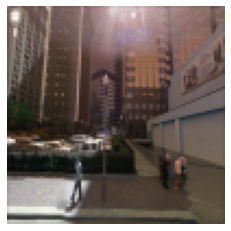

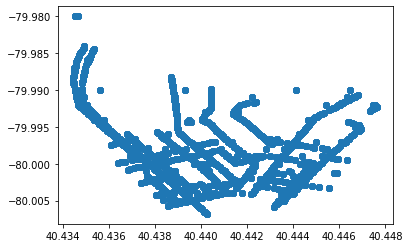

In [3]:
num_imgs = 6594
img_wid = 100
img_ht = 100
folders = [pitts_folder]
pitts_1_data, pitts_1_coords = new_dataset(folders=folders, num_instances=num_imgs, img_ht=img_ht, img_wid=img_wid )
print("pitts (1) shape: ", pitts_1_data.shape)
sample_dataset(dataset=pitts_1_data)

plot_coords(pitts_1_coords)

**Data**: Pittsburg (Pt.2)

pitts (2) shape:  (6594, 3, 100, 100)
original:  (3, 100, 100)
rehsaped:  (100, 100, 3)


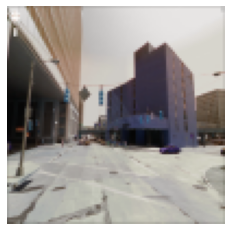

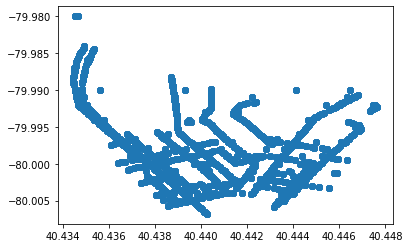

In [4]:
num_imgs = 6594
img_wid = 100
img_ht = 100
folders = [pitts_folder]
pitts_2_data, pitts_2_coords = new_dataset(folders=folders, num_instances=num_imgs, img_ht=img_ht, img_wid=img_wid )
print("pitts (2) shape: ", pitts_2_data.shape)
sample_dataset(dataset=pitts_2_data)

plot_coords(pitts_2_coords)

**Label** data by splitting with respect to **distance to K-cluster center**

num on left:  8268
num on right:  4920
torch.Size([13188, 3, 100, 100])


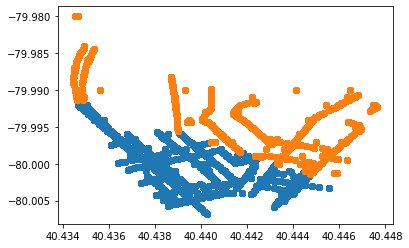

In [5]:
def label_data(data):
    # CLUSTER POINTS
    kmeans = KMeans(
        init="random",
        n_clusters=2,
        n_init=10,
        max_iter=300,
        random_state=42)
    
    kmeans.fit(data)
    clusters = kmeans.cluster_centers_
    
    plot_one = []
    plot_two = []
    
    labels = []
    for coord in data:
        if( abs(np.sum(coord - clusters[0])) > abs(np.sum(coord - clusters[1]) ) ): 
           labels.append(0)
           plot_one.append(coord)
        else: 
           labels.append(1)
           plot_two.append(coord)
    
    lats_one, lons_one = np.hsplit(np.array(plot_one), 2)
    lats_two, lons_two = np.hsplit(np.array(plot_two), 2)
    plt.scatter(lats_one, lons_one)
    plt.scatter(lats_two, lons_two)
           
    return np.array(labels)

# COORDS are the LABELS
total_images = np.vstack((pitts_1_data, pitts_2_data))
total_coords = np.vstack((pitts_1_coords, pitts_2_coords))
total_labels = label_data(total_coords)


# CHECK LABELS
print("num on left: ", np.sum(total_labels == 0))
print("num on right: ", np.sum(total_labels == 1))

# CONVERT numpy array to TENSOR
X = total_images
y = total_labels

mean = torch.from_numpy(X).mean()
std = torch.from_numpy(X).std()
transform_norm = T.Compose([
    T.Normalize(mean, std)
])

X = transform_norm(torch.from_numpy(X))

data = []
test = []
for i in range(len(X)):
    data.append([X[i], y[i]])

# CONSTRUCT data loaders
NUM_TRAIN = int(0.80 * len(data))
NUM_TOTAL = len(data)

loader_val = DataLoader(data, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))
loader_train = DataLoader(data, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))


print(X.shape)

In [6]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
# QUICK model creation based more or less off inception
model = nn.Sequential(
            # INPUT: (3, 100, 100) 
            # CNN LAYER: 30 5x5 channels
            nn.Conv2d(in_channels=3, out_channels=30, kernel_size=5),
    
            # INPUT: (30, 94, 94)
            # MAX-POOL: 3x3 filter
            nn.MaxPool2d(kernel_size=4, stride=2), 
    
            # INPUT: (30, 45, 45)
            # CNN LAYER: 20 3x3 channels
            nn.Conv2d(in_channels=30, out_channels=20, kernel_size=4, stride=2),
    
            # INPUT: (30, 20, 20)
            # CNN LAYER: 20 3x3 channels
            nn.MaxPool2d(kernel_size=4, stride=2),
            
            # INPUT: (20, 13, 13)
            nn.Flatten(),
            nn.Linear(in_features=2000, out_features=2, bias=True),
           
        )


In [7]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
def check_accuracy_part34(loader, model):
    print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def train_part34(model, optimizer, epochs=10, print_every=10):
    """    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    #model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [8]:
import copy
learn_rates = [0.0005]

for lr in learn_rates:

    optimizer = optim.SGD(model.parameters(), lr=lr,
                     momentum=0.9, nesterov=True)
    
    train_part34(model, optimizer, epochs=10)

/Users/stephen/miniforge3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration 0, loss = 0.6968
Checking accuracy on test set
Got 1474 / 2638 correct (55.88)

Iteration 10, loss = 0.6185
Checking accuracy on test set
Got 1669 / 2638 correct (63.27)

Iteration 20, loss = 0.5616
Checking accuracy on test set
Got 1690 / 2638 correct (64.06)

Iteration 30, loss = 0.5967
Checking accuracy on test set
Got 1803 / 2638 correct (68.35)

Iteration 40, loss = 0.6448
Checking accuracy on test set
Got 1811 / 2638 correct (68.65)

Iteration 50, loss = 0.6302
Checking accuracy on test set
Got 1751 / 2638 correct (66.38)

Iteration 60, loss = 0.6210
Checking accuracy on test set
Got 1820 / 2638 correct (68.99)

Iteration 70, loss = 0.5812
Checking accuracy on test set
Got 1807 / 2638 correct (68.50)

Iteration 80, loss = 0.5775
Checking accuracy on test set
Got 1779 / 2638 correct (67.44)

Iteration 90, loss = 0.5682
Checking accuracy on test set
Got 1831 / 2638 correct (69.41)

Iteration 100, loss = 0.5877
Checking accuracy on test set
Got 1843 / 2638 correct (69.86)


Iteration 50, loss = 0.4729
Checking accuracy on test set
Got 1943 / 2638 correct (73.65)

Iteration 60, loss = 0.5087
Checking accuracy on test set
Got 1954 / 2638 correct (74.07)

Iteration 70, loss = 0.6656
Checking accuracy on test set
Got 1920 / 2638 correct (72.78)

Iteration 80, loss = 0.5892
Checking accuracy on test set
Got 1926 / 2638 correct (73.01)

Iteration 90, loss = 0.3832
Checking accuracy on test set
Got 1939 / 2638 correct (73.50)

Iteration 100, loss = 0.5347
Checking accuracy on test set
Got 1950 / 2638 correct (73.92)

Iteration 110, loss = 0.5555
Checking accuracy on test set
Got 1880 / 2638 correct (71.27)

Iteration 120, loss = 0.4092
Checking accuracy on test set
Got 1949 / 2638 correct (73.88)

Iteration 130, loss = 0.5329
Checking accuracy on test set
Got 1930 / 2638 correct (73.16)

Iteration 140, loss = 0.4845
Checking accuracy on test set
Got 1960 / 2638 correct (74.30)

Iteration 150, loss = 0.4893
Checking accuracy on test set
Got 1949 / 2638 correct (7